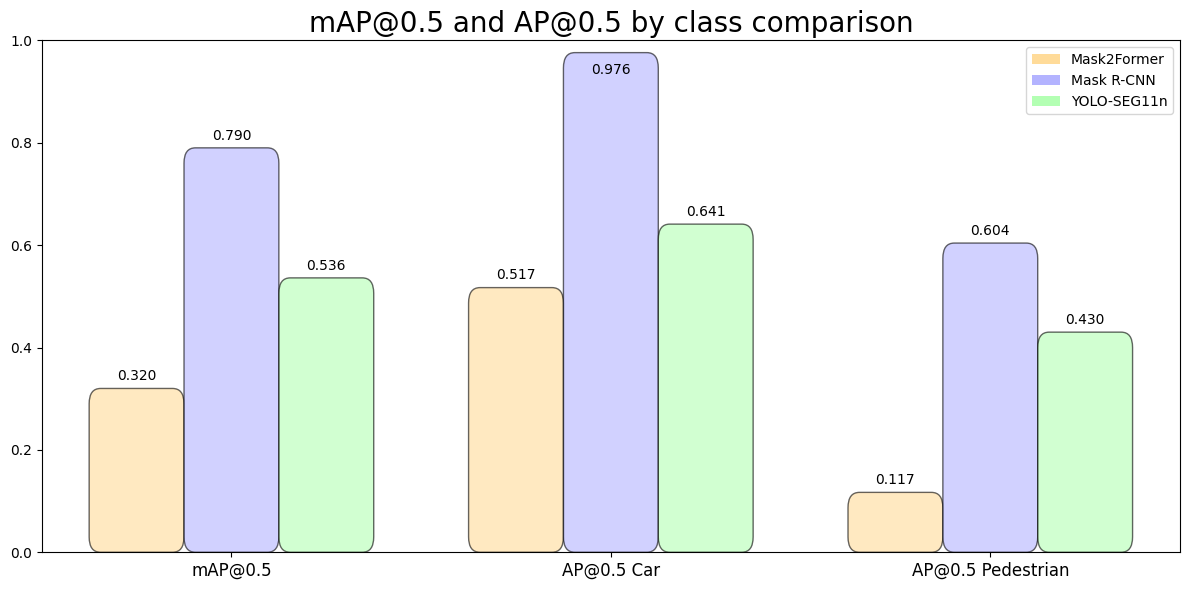

In [225]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch

# Data: mAP0.5, AP-car, AP-pedestrian
mask2former_data = [0.32, 0.517, 0.117]  # Datos del primer modelo
maskRCNN_data = [0.790, 0.976, 0.604]  # Datos del segundo modelo
yoloSEG_data = [0.536, 0.641, 0.430]  # Datos del tercer modelo

labels = ['mAP@0.5', 'AP@0.5 Car', 'AP@0.5 Pedestrian']

# Configuración del ancho de barras y posiciones
bar_width = 0.25
x = np.arange(len(labels))

# Colores para cada modelo
colors = ['#ffdb99', '#b3b3ff', '#b3ffb3']
#colors = ['#3daeb7', '#eeeeee', '#db643e']

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 6))

# Radio de las esquinas redondeadas
rounding_radius = 0.03

# Función para crear barras redondeadas
# def create_rounded_bar(x_pos, height, width, color, label, alpha=0.8):
#     patches = []
#     for i, h in enumerate(height):
#         # Crear una barra con esquinas redondeadas
#         patch = FancyBboxPatch(
#             (x_pos[i] - width/2, 0),  # (x, y)
#             width,                     # ancho
#             h,                         # altura
#             boxstyle=f"round,pad=0,rounding_size={rounding_radius}",
#             facecolor=color,
#             alpha=alpha
#         )
#         ax.add_patch(patch)
#         patches.append(patch)
        
#         # Añadir etiquetas de valores encima de cada barra
#         plt.text(x_pos[i], h + 0.01, f'{h:.3f}', ha='center', va='bottom')
#     return patches


# Función mejorada para crear barras redondeadas con posicionamiento inteligente de etiquetas
def create_rounded_bar(x_pos, height, width, color, label, alpha=0.8):
    patches = []
    # Umbral para determinar cuándo una barra está demasiado cerca del límite superior
    height_threshold = 0.9  
    
    for i, h in enumerate(height):
        # Crear una barra con esquinas redondeadas
        patch = FancyBboxPatch(
            (x_pos[i] - width/2, 0),  # (x, y)
            width,                     # ancho
            h,                         # altura
            boxstyle=f"round,pad=0,rounding_size={rounding_radius}",
            facecolor=color,
            alpha=alpha
        )
        ax.add_patch(patch)
        patches.append(patch)
        
        # Decidir si colocar la etiqueta encima o debajo según la altura
        if h > height_threshold:
            # Para barras muy altas, colocar la etiqueta dentro de la barra
            plt.text(x_pos[i], h - 0.02, f'{h:.3f}', 
                    ha='center', va='top', 
                    color='black')  # Texto en negrita para mejor visibilidad
        else:
            # Para barras normales, colocar la etiqueta encima
            plt.text(x_pos[i], h + 0.01, f'{h:.3f}', 
                    ha='center', va='bottom')
    
    return patches


# Crear barras redondeadas para cada modelo
alpha = 0.6
bars1 = create_rounded_bar(x - bar_width, mask2former_data, bar_width, colors[0], 'Modelo 1', alpha=alpha)
bars2 = create_rounded_bar(x, maskRCNN_data, bar_width, colors[1], 'Modelo 2', alpha=alpha)
bars3 = create_rounded_bar(x + bar_width, yoloSEG_data, bar_width, colors[2], 'Modelo 3', alpha=alpha)

# Agregar barras vacías para la leyenda (ya que no podemos usar los patches directamente)
dummy_bars = [plt.Rectangle((0,0), 1, 1, fc=color) for color in colors]
plt.legend(dummy_bars, ['Mask2Former', 'Mask R-CNN', 'YOLO-SEG11n'])

# Configurar el gráfico
plt.title('mAP@0.5 and AP@0.5 by class comparison', fontsize=20)
plt.xticks(x, labels, fontsize=12)
plt.ylim(0, 1.0)
plt.xlim(min(x) - bar_width*2, max(x) + bar_width*2)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Histograma guardado en: histograma_basico.png


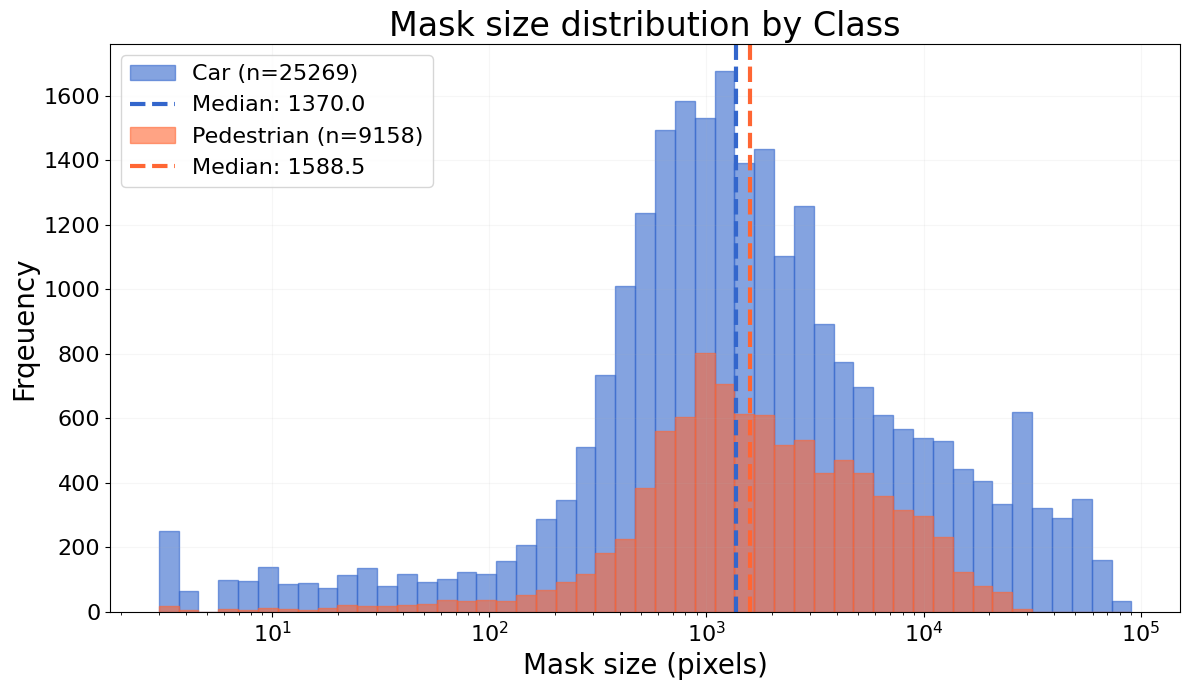

In [ ]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask as mask_util
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask as mask_util

def leer_tamanos_mascara_por_clase(directorio_predicciones):
    """
    Lee archivos de predicción COCO y extrae los tamaños de máscaras por clase.
    
    Args:
        directorio_predicciones: Directorio con los archivos JSON de predicciones.
    
    Returns:
        Dict: Diccionario con tamaños de máscaras organizados por clase.
    """
    # Mapeo de IDs de categoría a nombres de clase
    clases = {1: "car", 2: "pedestrian"}
    
    # Inicializar diccionario para almacenar tamaños por clase
    tamanos_por_clase = {clase: [] for clase in clases.values()}
    
    # Obtener todos los archivos JSON en el directorio
    archivos_json = sorted(glob.glob(os.path.join(directorio_predicciones, "*.json")))
    
    if not archivos_json:
        print(f"No se encontraron archivos JSON en {directorio_predicciones}")
        return tamanos_por_clase
    
    print(f"Procesando {len(archivos_json)} archivos JSON...")
    
    # Procesar cada archivo
    for archivo in archivos_json:
        try:
            with open(archivo, 'r') as f:
                predicciones = json.load(f)
            
            # Verificar formato de datos
            if isinstance(predicciones, dict) and 'annotations' in predicciones:
                predicciones = predicciones['annotations']
            
            # Procesar cada predicción
            for pred in predicciones:
                if 'segmentation' in pred and 'category_id' in pred:
                    category_id = pred['category_id']
                    
                    # Solo procesar clases de interés (car, pedestrian)
                    if category_id in clases:
                        nombre_clase = clases[category_id]
                        
                        # Obtener la máscara y calcular su tamaño
                        segmentation = pred['segmentation']
                        if isinstance(segmentation, dict):  # Formato RLE
                            mask_binary = mask_util.decode(segmentation)
                            mask_size = np.sum(mask_binary)  # Contar píxeles de la máscara
                            tamanos_por_clase[nombre_clase].append(int(mask_size))
                        
        except Exception as e:
            print(f"Error al procesar {os.path.basename(archivo)}: {e}")
    
    # Mostrar estadísticas de los datos leídos
    total_mascaras = sum(len(tamanos) for tamanos in tamanos_por_clase.values())
    if total_mascaras == 0:
        print("No se encontraron máscaras para analizar.")
    else:
        print(f"Se analizaron {total_mascaras} máscaras en total:")
        for clase, tamanos in tamanos_por_clase.items():
            if tamanos:
                print(f"  - {clase}: {len(tamanos)} máscaras")
                print(f"    Tamaño promedio: {np.mean(tamanos):.2f} píxeles")
    
    return tamanos_por_clase


def generar_histograma_tamanos(
    tamanos_por_clase, 
    ruta_salida=None, 
    num_bins=50, 
    escala_log=True,
    colores=None,
    mostrar_media=False,
    mostrar_mediana=True,
    mostrar_stats=False,
    titulo="Mask size distribution by Class"
):
    """
    Genera un histograma a partir de los datos de tamaños de máscaras por clase.
    
    Args:
        tamanos_por_clase: Diccionario con tamaños de máscaras organizados por clase.
        ruta_salida: Ruta para guardar el histograma (si es None, solo muestra).
        num_bins: Número de bins para el histograma.
        escala_log: Si es True, usa escala logarítmica en el eje X.
        colores: Diccionario con colores personalizados por clase (opcional).
        mostrar_media: Si es True, muestra líneas verticales para las medias.
        mostrar_mediana: Si es True, muestra líneas verticales para las medianas.
        mostrar_stats: Si es True, muestra cuadro con estadísticas detalladas.
        titulo: Título del gráfico.
    
    Returns:
        None
    """
    # Colores predeterminados si no se proporcionan
    if colores is None:
        colores = {
            "car": "#3366CC",       # Azul
            "pedestrian": "#FF6633"  # Naranja-rojo
        }
    
    # Verificar si tenemos datos
    total_mascaras = sum(len(tamanos) for tamanos in tamanos_por_clase.values())
    if total_mascaras == 0:
        print("No hay datos para generar el histograma.")
        return
    
    # Crear figura para el histograma
    plt.figure(figsize=(12, 7))
    
    # Determinar rango para los bins
    todos_tamanos = []
    for tamanos in tamanos_por_clase.values():
        todos_tamanos.extend(tamanos)
    
    min_tamano = min(todos_tamanos) if todos_tamanos else 0
    max_tamano = max(todos_tamanos) if todos_tamanos else 100
    
    # Configurar bins (escala logarítmica o lineal)
    if escala_log and min_tamano > 0:
        bins = np.logspace(np.log10(max(1, min_tamano)), np.log10(max_tamano), num_bins)
        plt.xscale('log')
    else:
        bins = np.linspace(min_tamano, max_tamano, num_bins)
    
    # Generar histograma para cada clase
    for clase, tamanos in tamanos_por_clase.items():
        if tamanos:
            color = colores.get(clase, "#777777")
            plt.hist(tamanos, bins=bins, alpha=0.6, 
                    label=f"{clase.capitalize()} (n={len(tamanos)})", 
                    color=color, edgecolor=color, linewidth=1)
            
            # Agregar líneas para la mediana
            if mostrar_mediana:
                mediana = np.median(tamanos)
                plt.axvline(x=mediana, color=color, linestyle='--', alpha=1, linewidth=3,
                          label=f"Median: {mediana}")
    
    # Configurar el gráfico
    plt.xlabel("Mask size (pixels)", fontsize=20)
    plt.ylabel("Frqeuency", fontsize=20)
    plt.title(titulo, fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, alpha=0.1)
    plt.legend(loc='upper left', fontsize=16)
    
    plt.tight_layout()
    
    # Guardar o mostrar
    if ruta_salida:
        plt.savefig(ruta_salida, dpi=300, bbox_inches='tight')
        print(f"Histograma guardado en: {ruta_salida}")
    else:
        plt.show()


# Plot
directorio = '/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/week2/Evaluation_off-the-shelf/preds_off-the-shelf'
datos_tamanos = leer_tamanos_mascara_por_clase(directorio)
generar_histograma_tamanos(
    tamanos_por_clase=datos_tamanos,
    ruta_salida="histograma_basico.png"
)

In [70]:
import os
import json
import glob
import numpy as np
import cv2
from pycocotools import mask as mask_util
from typing import Dict, Optional

def crear_video_con_mascaras(
    directorio_frames: str,
    archivo_predicciones: str,
    video_salida: str,
    mapa_categorias: Optional[Dict[int, str]] = None,
    fps: int = 30,
    alfa_mascara: float = 0.5,
    umbral_score: float = 0.0
):
    """
    Crea un vídeo a partir de frames con máscaras de segmentación superpuestas.
    
    Args:
        directorio_frames: Directorio que contiene los frames del vídeo.
        archivo_predicciones: Archivo JSON con predicciones en formato COCO.
        video_salida: Ruta del archivo de vídeo de salida.
        mapa_categorias: Diccionario que mapea category_id a nombres de categoría.
        fps: Fotogramas por segundo del vídeo (default: 30).
        alfa_mascara: Transparencia de las máscaras (0-1, donde 1 es opaco).
        umbral_score: Puntuación mínima para mostrar una predicción.
    """
    # 1. Cargar predicciones
    with open(archivo_predicciones, 'r') as f:
        predicciones = json.load(f)
    
    # 2. Buscar frames en el directorio
    archivos_frames = sorted(glob.glob(os.path.join(directorio_frames, "*.jpg")) + 
                            glob.glob(os.path.join(directorio_frames, "*.png")))
    
    if not archivos_frames:
        raise ValueError(f"No se encontraron imágenes en {directorio_frames}")
    
    # 3. Obtener dimensiones del vídeo
    primer_frame = cv2.imread(archivos_frames[0])
    if primer_frame is None:
        raise ValueError(f"No se pudo leer la imagen: {archivos_frames[0]}")
    
    altura, ancho = primer_frame.shape[:2]
    
    # 4. Configurar el escritor de vídeo
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec para MP4
    escritor_video = cv2.VideoWriter(video_salida, fourcc, fps, (ancho, altura))
    
    # 5. Organizar predicciones por image_id
    predicciones_por_imagen = {}
    for pred in predicciones:
        image_id = pred['image_id']
        if image_id not in predicciones_por_imagen:
            predicciones_por_imagen[image_id] = []
        
        if pred.get('score', 1.0) >= umbral_score:
            predicciones_por_imagen[image_id].append(pred)
    
    # 6. Generar colores para cada categoría
    np.random.seed(42)  # Para reproducibilidad
    categorias_unicas = set(pred['category_id'] for pred in predicciones)
    colores_categoria = {
        cat_id: tuple(map(int, np.random.randint(50, 255, 3)))  # BGR
        for cat_id in categorias_unicas
    }
    
    # 7. Procesar cada frame
    print(f"Procesando {len(archivos_frames)} frames...")
    for i, ruta_frame in enumerate(archivos_frames):
        print(f"Frame {i+1}/{len(archivos_frames)}")
        
        # Cargar imagen
        frame = cv2.imread(ruta_frame)
        if frame is None:
            print(f"Error al leer: {ruta_frame}. Saltando.")
            continue
        
        # Crear capa para las máscaras
        capa_mascaras = np.zeros_like(frame)
        
        # Determinar image_id para este frame (imagen i+1)
        image_id = i + 1
        frame_preds = predicciones_por_imagen.get(image_id, [])
        
        # Dibujar cada predicción
        for pred in frame_preds:
            category_id = pred['category_id']
            color = colores_categoria[category_id]
            score = pred.get('score', 1.0)
            
            # Obtener máscara RLE y decodificarla
            rle = pred['segmentation']
            mascara_binaria = mask_util.decode(rle)
            
            # Aplicar color a la máscara
            capa_mascaras[mascara_binaria == 1] = color
            
            # Obtener nombre de categoría
            if mapa_categorias and category_id in mapa_categorias:
                nombre_categoria = mapa_categorias[category_id]
            else:
                nombre_categoria = f"Clase {category_id}"
            
            # Preparar texto para la etiqueta
            texto = nombre_categoria
            if 'score' in pred:
                texto += f" {score:.2f}"
            
            # Obtener bbox
            bbox = pred['bbox']  # [x, y, width, height]
            x, y = int(bbox[0]), int(bbox[1])
            w, h = int(bbox[2]), int(bbox[3])
            
            # Dibujar bbox
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            
            # Posición para el texto
            y_texto = y - 10
            if y_texto < 10:
                y_texto = y + h + 20
            
            # Dibujar fondo para el texto
            tamano_texto, _ = cv2.getTextSize(texto, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv2.rectangle(frame, 
                         (x, y_texto - tamano_texto[1] - 2), 
                         (x + tamano_texto[0], y_texto + 2), 
                         (0, 0, 0), -1)
            
            # Dibujar texto
            cv2.putText(frame, texto, (x, y_texto), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        
        # Combinar frame con máscaras
        resultado = cv2.addWeighted(frame, 1.0, capa_mascaras, alfa_mascara, 0)
        
        # Escribir frame al vídeo
        escritor_video.write(resultado)
    
    # 8. Liberar recursos
    escritor_video.release()
    print(f"Vídeo creado exitosamente: {video_salida}")


In [73]:
# Ejemplo de uso
mapa_categorias = {
    1: "car",
    2: "pedestrian",
    # Agrega más categorías según necesites
}

preds = '/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/KITTI_MOTS/training/image_01/preds_coco_0003.json'
frames = '/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/KITTI_MOTS/training/image_01/0003'

crear_video_con_mascaras(
    directorio_frames=frames,
    archivo_predicciones=preds,
    video_salida="video_con_mascaras.mp4",
    mapa_categorias=mapa_categorias,
    fps=15,
    alfa_mascara=0.6,
    umbral_score=0.5  # Solo muestra objetos con confianza > 0.5
)


Procesando 144 frames...
Frame 1/144
Frame 2/144
Frame 3/144
Frame 4/144
Frame 5/144
Frame 6/144
Frame 7/144
Frame 8/144
Frame 9/144
Frame 10/144
Frame 11/144
Frame 12/144
Frame 13/144
Frame 14/144
Frame 15/144
Frame 16/144
Frame 17/144
Frame 18/144
Frame 19/144
Frame 20/144
Frame 21/144
Frame 22/144
Frame 23/144
Frame 24/144
Frame 25/144
Frame 26/144
Frame 27/144
Frame 28/144
Frame 29/144
Frame 30/144
Frame 31/144
Frame 32/144
Frame 33/144
Frame 34/144
Frame 35/144
Frame 36/144
Frame 37/144
Frame 38/144
Frame 39/144
Frame 40/144
Frame 41/144
Frame 42/144
Frame 43/144
Frame 44/144
Frame 45/144
Frame 46/144
Frame 47/144
Frame 48/144
Frame 49/144
Frame 50/144
Frame 51/144
Frame 52/144
Frame 53/144
Frame 54/144
Frame 55/144
Frame 56/144
Frame 57/144
Frame 58/144
Frame 59/144
Frame 60/144
Frame 61/144
Frame 62/144
Frame 63/144
Frame 64/144
Frame 65/144
Frame 66/144
Frame 67/144
Frame 68/144
Frame 69/144
Frame 70/144
Frame 71/144
Frame 72/144
Frame 73/144
Frame 74/144
Frame 75/144
Frame 76/

In [89]:
import os
import glob
import re

def procesar_videos_seleccionados(
    directorio_base,
    videos_a_procesar,  # Lista de IDs de video a procesar (ej: ["0001", "0003"])
    directorio_salida="videos_con_mascaras",
    mapa_categorias=None,
    fps=15,
    alfa_mascara=0.6,
    umbral_score=0.5
):
    """
    Procesa solo los videos seleccionados y crea videos con máscaras de segmentación.
    
    Args:
        directorio_base: Directorio que contiene archivos de predicciones y carpetas de frames.
        videos_a_procesar: Lista de IDs de videos a procesar (ej: ["0001", "0003"]).
        directorio_salida: Directorio donde se guardarán los videos generados.
        mapa_categorias: Diccionario que mapea category_id a nombres de categoría.
        fps: Fotogramas por segundo del video.
        alfa_mascara: Transparencia de las máscaras (0-1).
        umbral_score: Puntuación mínima para mostrar objetos.
    """
    # Crear directorio de salida si no existe
    if not os.path.exists(directorio_salida):
        os.makedirs(directorio_salida)
        print(f"Creado directorio de salida: {directorio_salida}")
    
    # Definir mapa de categorías por defecto si no se proporciona
    if mapa_categorias is None:
        mapa_categorias = {
            1: "car",
            2: "pedestrian",
            # Añadir más categorías según sea necesario
        }
    
    # Procesar cada video de la lista
    videos_procesados = 0
    for video_id in videos_a_procesar:
        # Construir la ruta al archivo de predicciones
        folder_preds = '/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/huggingface/week2/Evaluation_off-the-shelf/test_set/preds_off-the-shelf'
        archivo_pred = os.path.join(folder_preds, f"preds_coco_{video_id}.json")
        
        # Verificar que existe el archivo de predicciones
        if not os.path.exists(archivo_pred):
            print(f"⚠️ No se encontró el archivo de predicciones para el video {video_id}. Saltando.")
            continue
        
        # Construir la ruta al directorio de frames
        directorio_frames = os.path.join(directorio_base, video_id)
        
        # Verificar que existe el directorio de frames
        if not os.path.exists(directorio_frames):
            print(f"⚠️ No se encontró el directorio de frames para el video {video_id}. Saltando.")
            continue
        
        # Nombre del archivo de salida
        nombre_salida = f"video_con_mascaras_{video_id}.mp4"
        ruta_salida = os.path.join(directorio_salida, nombre_salida)
        
        # Mostrar progreso
        print(f"[{videos_procesados+1}/{len(videos_a_procesar)}] Procesando video {video_id}...")
        
        try:
            # Llamar a la función para crear el video
            crear_video_con_mascaras(
                directorio_frames=directorio_frames,
                archivo_predicciones=archivo_pred,
                video_salida=ruta_salida,
                mapa_categorias=mapa_categorias,
                fps=fps,
                alfa_mascara=alfa_mascara,
                umbral_score=umbral_score
            )
            print(f"✅ Video creado: {ruta_salida}")
            videos_procesados += 1
        except Exception as e:
            print(f"❌ Error al procesar {video_id}: {str(e)}")
    
    print(f"\nProcesamiento completado. Se generaron {videos_procesados} videos en: {os.path.abspath(directorio_salida)}")

# Ejemplo de uso:
directorio_base = '/Users/arnaubarrera/Desktop/MSc Computer Vision/C5. Visual Recognition/mcv-c5-group-3/KITTI_MOTS/training/image_02'

# Definir mapa de categorías
mapa_categorias = {
    1: "car",
    2: "pedestrian",
    # Agrega más categorías según necesites
}

# Lista de videos a procesar (solo estos serán procesados)
videos_a_procesar = ["0016", "0017", "0018", "0019", "0020"]  # Reemplaza con tus IDs de video deseados

# Procesar solo los videos seleccionados
procesar_videos_seleccionados(
    directorio_base=directorio_base,
    videos_a_procesar=videos_a_procesar,
    directorio_salida="results_off-the-shelf",
    mapa_categorias=mapa_categorias,
    fps=15,
    alfa_mascara=0.6,
    umbral_score=0.5
)


[1/5] Procesando video 0016...
Procesando 209 frames...
Frame 1/209
Frame 2/209
Frame 3/209
Frame 4/209
Frame 5/209
Frame 6/209
Frame 7/209
Frame 8/209
Frame 9/209
Frame 10/209
Frame 11/209
Frame 12/209
Frame 13/209
Frame 14/209
Frame 15/209
Frame 16/209
Frame 17/209
Frame 18/209
Frame 19/209
Frame 20/209
Frame 21/209
Frame 22/209
Frame 23/209
Frame 24/209
Frame 25/209
Frame 26/209
Frame 27/209
Frame 28/209
Frame 29/209
Frame 30/209
Frame 31/209
Frame 32/209
Frame 33/209
Frame 34/209
Frame 35/209
Frame 36/209
Frame 37/209
Frame 38/209
Frame 39/209
Frame 40/209
Frame 41/209
Frame 42/209
Frame 43/209
Frame 44/209
Frame 45/209
Frame 46/209
Frame 47/209
Frame 48/209
Frame 49/209
Frame 50/209
Frame 51/209
Frame 52/209
Frame 53/209
Frame 54/209
Frame 55/209
Frame 56/209
Frame 57/209
Frame 58/209
Frame 59/209
Frame 60/209
Frame 61/209
Frame 62/209
Frame 63/209
Frame 64/209
Frame 65/209
Frame 66/209
Frame 67/209
Frame 68/209
Frame 69/209
Frame 70/209
Frame 71/209
Frame 72/209
Frame 73/209
Fram

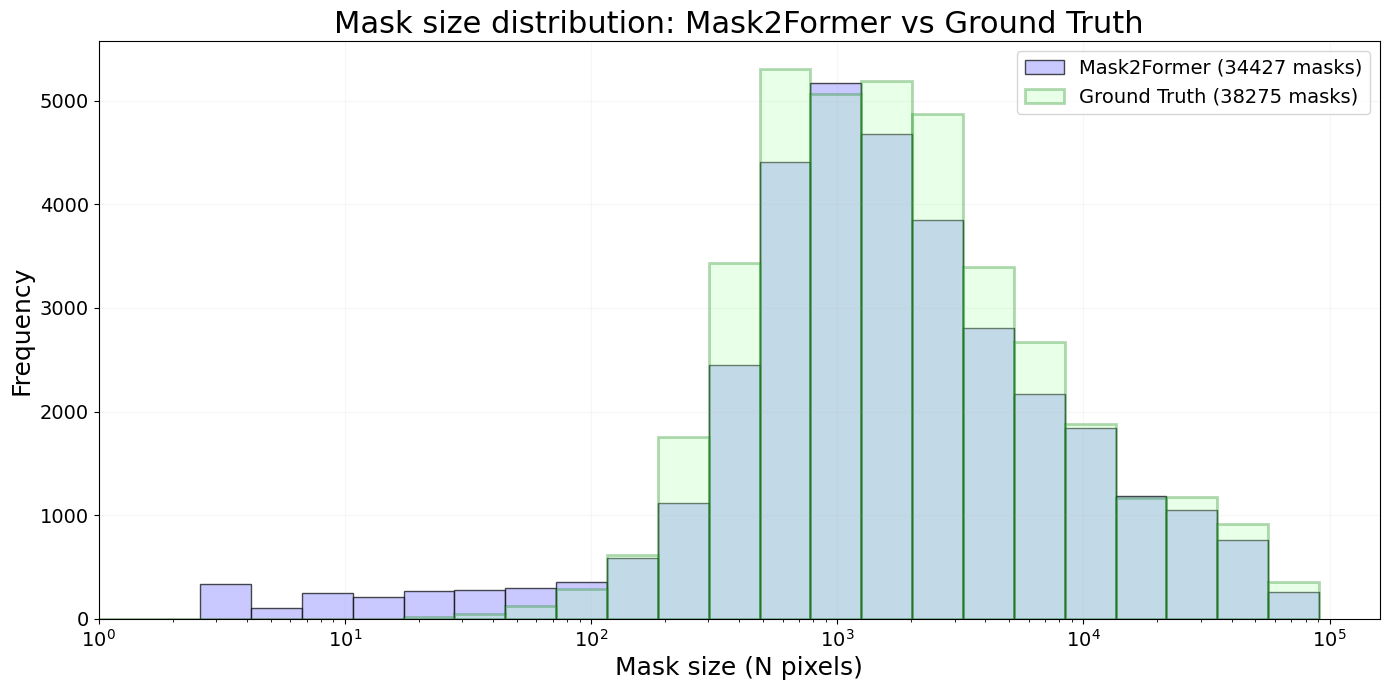

In [226]:
def generar_histograma(
    datos_principal=None,
    datos_secundario=None,
    datos_terciario=None,
    num_bins=50,
    escala_log=True,
    normalizar=False,
    titulo="Distribución de tamaños de máscaras",
    etiquetas=None,
    colores=None,
    ancho=14,
    alto=7
):
    """
    Función unificada para generar histogramas de tamaños de máscaras.
    
    Args:
        datos_principal: Dict con {'mask_sizes': [lista]} para datos principales (Predicciones)
        datos_secundario: Dict con {'mask_sizes': [lista]} o None para datos secundarios (GT)
        datos_terciario: Ruta a archivo .npy o array numpy o None
        ruta_salida: Ruta para guardar el histograma (si es None, solo muestra)
        num_bins: Número de bins para el histograma
        escala_log: Si es True, usa escala logarítmica en el eje X
        normalizar: Si es True, normaliza los histogramas (density=True)
        titulo: Título del gráfico
        etiquetas: Dict con nombres personalizados {'principal', 'secundario', 'terciario'}
        colores: Dict con colores {'principal', 'secundario', 'terciario'}
        ancho: Ancho de la figura en pulgadas
        alto: Alto de la figura en pulgadas
    """
    # Valores por defecto
    if etiquetas is None:
        etiquetas = {
            'principal': 'Mask2Former',
            'secundario': 'Ground Truth',
            'terciario': 'Datos externos'
        }
    
    if colores is None:
        colores = {
            'principal': '#b3b3ff',  # Azul
            'secundario': '#b3ffb3',   # Verde
            'terciario': '#ff6b35'   # Naranja
        }
    
    plt.figure(figsize=(ancho, alto))
    
    # Recopilación de datos para el histograma
    datasets = []
        
    # Datos principales
    if datos_principal and 'mask_sizes' in datos_principal:
        datasets.append({
            'data': datos_principal['mask_sizes'],
            'color': colores['principal'],
            'label': etiquetas['principal'],
            'alpha': 0.7,
            'edgecolor': 'black',
            'tipo': 'barra'
        })

    # Datos secundarios (GT)
    if datos_secundario and 'mask_sizes' in datos_secundario:
        datasets.append({
            'data': datos_secundario['mask_sizes'],
            'color': 'white' if datos_terciario else colores['secundario'],
            'edgecolor': 'green',
            'linewidth': 2,
            'label': etiquetas['secundario'],
            'alpha': 0.3,  # GT como contorno si hay 3 distribuciones
            'tipo': 'barra'
        })
    
    # Datos terciarios (.npy)
    if datos_terciario is not None:
        # Cargar datos si es una ruta
        if isinstance(datos_terciario, str):
            try:
                datos_npy = np.load(datos_terciario)
                print(f"Cargados {len(datos_npy)} valores de {datos_terciario}")
            except Exception as e:
                print(f"Error al cargar {datos_terciario}: {e}")
                datos_npy = np.array([])
        else:
            datos_npy = datos_terciario
        
        if len(datos_npy) > 0:
            datasets.append({
                'data': datos_npy,
                'color': colores['terciario'],
                'label': etiquetas['terciario'],
                'alpha': 0.6,
                'edgecolor': 'black',
                'tipo': 'barra'
            })
    
    # Si no hay datos, mostrar mensaje
    if not datasets or all(len(d['data']) == 0 for d in datasets):
        plt.text(0.5, 0.5, "Sin datos para visualizar", ha='center', va='center', fontsize=14)
    else:
        # Determinar bins comunes para todos los datasets
        min_vals = [np.min(d['data']) for d in datasets if len(d['data']) > 0]
        max_vals = [np.max(d['data']) for d in datasets if len(d['data']) > 0]
        
        min_val = min(min_vals) if min_vals else 0
        max_val = max(max_vals) if max_vals else 100
        
        if escala_log and min_val > 0:
            bins = np.logspace(np.log10(max(1, min_val)), np.log10(max_val), num_bins)
            plt.xscale('log')
        else:
            bins = np.linspace(min_val, max_val, num_bins)
        
        # Plotear cada dataset
        for dataset in datasets:
            plt.hist(
                dataset['data'], 
                bins=bins, 
                alpha=dataset.get('alpha', 0.7), 
                color=dataset['color'],
                edgecolor=dataset.get('edgecolor'),
                linewidth=dataset.get('linewidth', 1),
                label=f"{dataset['label']} ({len(dataset['data'])} masks)",
                density=normalizar
            )
    
    # Configuración gráfica
    plt.xlabel("Mask size (N pixels)", fontsize=18)
    plt.ylabel("Densidad" if normalizar else "Frequency", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(left=1)
    plt.title(titulo, fontsize=22)
    plt.legend(loc='upper right', fontsize=14)
    plt.grid(True, alpha=0.1)
    plt.tight_layout()
    plt.show()

# 3. Histograma completo con las tres distribuciones
generar_histograma(
    datos_principal=pred_sizes,
    datos_secundario=gt_sizes,
    titulo="Mask size distribution: Mask2Former vs Ground Truth",
    normalizar=False,
    num_bins=25
)